# Проект 4. Компьютер говорит нет

## Задание
Написать скоринговую модель предсказания дефолта клиентов банка

#### Хомич А.В. 33_group_dst-19

##### Импортируем необходимые библиотеки

In [5898]:
import pandas as pd
from pandas import Series
import pandas as pd
import numpy as np
import datetime
import warnings
#from pandas_ml import ConfusionMatrix

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

##### Прочитаем данные и обозначим константу RANDOM_SEED

In [5899]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')


#DATA_DIR = '/kaggle/input/sf-dst-scoring/'
#train = pd.read_csv(DATA_DIR+'/train.csv')
#test = pd.read_csv(DATA_DIR+'test.csv')
#sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

RANDOM_SEED = 42

##### Объединим data и test

Для корректной обработки данных объединим датасеты train и test в один датасет. С помощью столбца sample пометим, где train, а где test. default мы должны предсказать. Пока заполним default в тестовой части нулями.

In [5900]:
train['sample'] = 1 
test['sample'] = 0 
test['default'] = 0 

data = test.append(train, sort=False).reset_index(drop=True)


In [5901]:
print('Датасет train', train.shape)
print('Датасет test', test.shape)
print('Датасет train+test ', data.shape)

Датасет train (73799, 20)
Датасет test (36349, 20)
Датасет train+test  (110148, 20)


##### Посмотрим на данные

In [5902]:
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,04MAR2014,GRD,F,45,N,N,0,0,-1.792064,3,50,1,2,17000,4,4,N,1,0
110144,76821,24MAR2014,SCH,M,41,Y,Y,0,0,-2.058029,1,50,2,2,70000,1,4,N,1,0
110145,103695,22APR2014,SCH,M,31,N,N,0,0,-1.512635,4,80,2,3,45000,2,2,N,1,0
110146,861,04JAN2014,SCH,F,29,N,N,0,1,-1.479334,3,50,1,3,13000,2,3,N,1,1


##### Видим, что датасет состоит из 110148 строк и 20 столбцов. Рассмотрим, какие данные имеются в датасете.

client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

##### Посмотрим на типы данных и наличие пропусков с помощью метода .info()

In [5903]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

##### Видим, что в столбце education имеются пропуски. Также видим, что некоторые данные имеют тип object

##### Посмотрим ближе столбец education и заполним пропуски

In [5904]:
data['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

In [5905]:
data['education'].fillna(0, inplace = True)

In [5906]:
data['education'].value_counts()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
0        478
ACD      291
Name: education, dtype: int64

##### Заменим пропуск модой - самой часто встречающейся категорией. В данном случае это категория SCH.

In [5907]:
data['education'].fillna(data['education'].value_counts().index[0], inplace = True)
data['education'].replace(0, data['education'].value_counts().index[0] , inplace = True)

In [5908]:
data['education'].value_counts()

SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

##### Теперь в данных пропуски отсутствуют

## Преобразование типов данных

In [5909]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         110148 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

##### Можем заметить, что категориальные переменные home_address и work_address имеют тип int64. Преобразуем в тип object

In [5910]:
for i in ['home_address', 'work_address']:
    data[i] = data[i].astype('object')

#### Рассмотрим признак app_date. 

##### Он имеет тип object. Разобьем данный признак на два новых признака: 1. app_month - месяц подачи заявки. 2. app_year - год подачи заявки;


In [5911]:
data['app_date'].value_counts()

18MAR2014    1491
19MAR2014    1363
17MAR2014    1350
31MAR2014    1317
07APR2014    1296
             ... 
20APR2014     359
07JAN2014     349
03JAN2014     313
02JAN2014     204
01JAN2014      56
Name: app_date, Length: 120, dtype: int64

Для начала преобразуем в тип datetime

In [5912]:
data.app_date = pd.to_datetime(data.app_date)

In [5913]:
data.insert(1, 'app_month', data['app_date'].dt.month)

In [5914]:
data.insert(2, 'app_year', data['app_date'].dt.year)

##### Проверим, в какие год и месяц чаще подавали заявку на кредит

In [5915]:
data['app_year'].unique()

array([2014], dtype=int64)

In [5916]:
data['app_month'].unique()


array([3, 1, 2, 4], dtype=int64)

В данном датасете собраны заявки только за 2014 год. Поэтому столбец app_year не даст полезной информации, удалим его. Также можно увидеть, что данные даны только за январь, февраль, март и апрель.

In [5917]:
del data['app_year']

##### Посмотрим, в каком месяце чаще подавали заявку. 

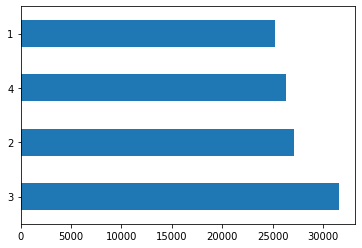

In [5918]:
data['app_month'].value_counts().plot.barh()

Наибольшее количество заявок наблюдается в феврале и марте. Скорее всего после новогодних праздников людям не хватает денежных средста, а в январе, возможно, меньше заявок из-за того, что на начало января приходятся праздничные дни. Некоторые банки закрыты. Создадим два признака, которые будут показывать, заявка была подана в начале месяца, или в конце месяца. Данный признак будет бинарный. Назовем их app_first_month_day (первая половина месяца) и app_second_month_day (вторая половина месяца). 15-е чило включим в первую половину.

In [5919]:
data.insert(1, 'app_day', data['app_date'].dt.day)        

In [5920]:
app_firs_month_day = []
app_second_month_day = []
for i in data['app_day']:
    if ((i < 15)|(i==15)):
        app_firs_month_day.append(1)
        app_second_month_day.append(0)
    else:
        app_firs_month_day.append(0)
        app_second_month_day.append(1)

In [5921]:
data.insert(2, 'app_firs_month_day', app_firs_month_day)

In [5922]:
data.insert(3, 'app_second_month_day', app_second_month_day)

##### Удалим лишние столбцы

In [5923]:
del data['app_date']
del data['app_day']

In [5924]:
data

,client_id,app_firs_month_day,app_second_month_day,app_month,education,sex,age,car,car_type,decline_app_cnt,...,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,0,1,3,GRD,M,29,Y,Y,0,...,3,50,1,2,50000,1,4,N,0,0
1,17527,0,1,1,SCH,F,39,N,N,5,...,2,50,1,2,5000,4,3,N,0,0
2,75683,0,1,3,UGR,M,50,Y,Y,0,...,1,50,1,2,30000,1,3,Y,0,0
3,26883,1,0,2,SCH,M,56,N,N,0,...,1,40,1,2,17000,1,3,N,0,0
4,28862,1,0,2,GRD,F,38,N,N,0,...,0,80,2,3,120000,1,3,N,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,1,0,3,GRD,F,45,N,N,0,...,3,50,1,2,17000,4,4,N,1,0
110144,76821,0,1,3,SCH,M,41,Y,Y,0,...,1,50,2,2,70000,1,4,N,1,0
110145,103695,0,1,4,SCH,M,31,N,N,0,...,4,80,2,3,45000,2,2,N,1,0
110146,861,1,0,1,SCH,F,29,N,N,0,...,3,50,1,3,13000,2,3,N,1,1


##### Снова посмотрим на данные

In [5925]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             110148 non-null  int64  
 1   app_firs_month_day    110148 non-null  int64  
 2   app_second_month_day  110148 non-null  int64  
 3   app_month             110148 non-null  int64  
 4   education             110148 non-null  object 
 5   sex                   110148 non-null  object 
 6   age                   110148 non-null  int64  
 7   car                   110148 non-null  object 
 8   car_type              110148 non-null  object 
 9   decline_app_cnt       110148 non-null  int64  
 10  good_work             110148 non-null  int64  
 11  score_bki             110148 non-null  float64
 12  bki_request_cnt       110148 non-null  int64  
 13  region_rating         110148 non-null  int64  
 14  home_address          110148 non-null  object 
 15  

##### Категориальный признак app_month имеет тип int64. Сделаем его типом object

In [5926]:
for i in ['app_month']:
    data[i] = data[i].astype('object')

In [5927]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             110148 non-null  int64  
 1   app_firs_month_day    110148 non-null  int64  
 2   app_second_month_day  110148 non-null  int64  
 3   app_month             110148 non-null  object 
 4   education             110148 non-null  object 
 5   sex                   110148 non-null  object 
 6   age                   110148 non-null  int64  
 7   car                   110148 non-null  object 
 8   car_type              110148 non-null  object 
 9   decline_app_cnt       110148 non-null  int64  
 10  good_work             110148 non-null  int64  
 11  score_bki             110148 non-null  float64
 12  bki_request_cnt       110148 non-null  int64  
 13  region_rating         110148 non-null  int64  
 14  home_address          110148 non-null  object 
 15  

#### Рассмотрим категориальный признак education

##### Уровень образования можно преобразовать в числовлй признак
SCH - school (присвоим 1);
UGR - undergraduate (Bachelor) (присвоим 2);
GRD - graduate (присвоим 3);
PGR - postgraduate (присвоим 4);
ACD - Academic Career Develipment (присвоим 5);

In [5928]:
data['education'].replace('SCH', 1 , inplace = True)
data['education'].replace('UGR', 2 , inplace = True)
data['education'].replace('GRD', 3 , inplace = True)
data['education'].replace('PGR', 4 , inplace = True)
data['education'].replace('ACD', 5 , inplace = True)


## Переименование категорий данных

##### Для переименования будем использовать метод map

Снова посмотрим на данные

In [5929]:
data

,client_id,app_firs_month_day,app_second_month_day,app_month,education,sex,age,car,car_type,decline_app_cnt,...,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,0,1,3,3,M,29,Y,Y,0,...,3,50,1,2,50000,1,4,N,0,0
1,17527,0,1,1,1,F,39,N,N,5,...,2,50,1,2,5000,4,3,N,0,0
2,75683,0,1,3,2,M,50,Y,Y,0,...,1,50,1,2,30000,1,3,Y,0,0
3,26883,1,0,2,1,M,56,N,N,0,...,1,40,1,2,17000,1,3,N,0,0
4,28862,1,0,2,3,F,38,N,N,0,...,0,80,2,3,120000,1,3,N,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,1,0,3,3,F,45,N,N,0,...,3,50,1,2,17000,4,4,N,1,0
110144,76821,0,1,3,1,M,41,Y,Y,0,...,1,50,2,2,70000,1,4,N,1,0
110145,103695,0,1,4,1,M,31,N,N,0,...,4,80,2,3,45000,2,2,N,1,0
110146,861,1,0,1,1,F,29,N,N,0,...,3,50,1,3,13000,2,3,N,1,1


##### Переименуем названия месяца в столбце app_month

In [5930]:
month = {1: 'January', 2: 'February', 3: 'March', 4: 'April'}

In [5931]:
data['app_month'] = data['app_month'].map(month)

In [5932]:
data

,client_id,app_firs_month_day,app_second_month_day,app_month,education,sex,age,car,car_type,decline_app_cnt,...,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,0,1,March,3,M,29,Y,Y,0,...,3,50,1,2,50000,1,4,N,0,0
1,17527,0,1,January,1,F,39,N,N,5,...,2,50,1,2,5000,4,3,N,0,0
2,75683,0,1,March,2,M,50,Y,Y,0,...,1,50,1,2,30000,1,3,Y,0,0
3,26883,1,0,February,1,M,56,N,N,0,...,1,40,1,2,17000,1,3,N,0,0
4,28862,1,0,February,3,F,38,N,N,0,...,0,80,2,3,120000,1,3,N,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,1,0,March,3,F,45,N,N,0,...,3,50,1,2,17000,4,4,N,1,0
110144,76821,0,1,March,1,M,41,Y,Y,0,...,1,50,2,2,70000,1,4,N,1,0
110145,103695,0,1,April,1,M,31,N,N,0,...,4,80,2,3,45000,2,2,N,1,0
110146,861,1,0,January,1,F,29,N,N,0,...,3,50,1,3,13000,2,3,N,1,1


##### Переименуем название пола

In [5933]:
sex = {'M': 'Male', 'F': 'Female'}
data['sex'] = data['sex'].map(sex)
data

,client_id,app_firs_month_day,app_second_month_day,app_month,education,sex,age,car,car_type,decline_app_cnt,...,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,0,1,March,3,Male,29,Y,Y,0,...,3,50,1,2,50000,1,4,N,0,0
1,17527,0,1,January,1,Female,39,N,N,5,...,2,50,1,2,5000,4,3,N,0,0
2,75683,0,1,March,2,Male,50,Y,Y,0,...,1,50,1,2,30000,1,3,Y,0,0
3,26883,1,0,February,1,Male,56,N,N,0,...,1,40,1,2,17000,1,3,N,0,0
4,28862,1,0,February,3,Female,38,N,N,0,...,0,80,2,3,120000,1,3,N,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,1,0,March,3,Female,45,N,N,0,...,3,50,1,2,17000,4,4,N,1,0
110144,76821,0,1,March,1,Male,41,Y,Y,0,...,1,50,2,2,70000,1,4,N,1,0
110145,103695,0,1,April,1,Male,31,N,N,0,...,4,80,2,3,45000,2,2,N,1,0
110146,861,1,0,January,1,Female,29,N,N,0,...,3,50,1,3,13000,2,3,N,1,1


##### Также изменим столбцы о наличии автомобиля, о типе автомобиля и о наличии загран паспорта на 0 и 1

In [5934]:
car = {'Y': 1, 'N': 0}
data['car'] = data['car'].map(car)

car_type = {'Y': 1, 'N': 0}
data['car_type'] = data['car_type'].map(car_type)

foreign_passport = {'Y': 1, 'N': 0}
data['foreign_passport'] = data['foreign_passport'].map(foreign_passport)


In [5935]:
data

,client_id,app_firs_month_day,app_second_month_day,app_month,education,sex,age,car,car_type,decline_app_cnt,...,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,0,1,March,3,Male,29,1,1,0,...,3,50,1,2,50000,1,4,0,0,0
1,17527,0,1,January,1,Female,39,0,0,5,...,2,50,1,2,5000,4,3,0,0,0
2,75683,0,1,March,2,Male,50,1,1,0,...,1,50,1,2,30000,1,3,1,0,0
3,26883,1,0,February,1,Male,56,0,0,0,...,1,40,1,2,17000,1,3,0,0,0
4,28862,1,0,February,3,Female,38,0,0,0,...,0,80,2,3,120000,1,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,1,0,March,3,Female,45,0,0,0,...,3,50,1,2,17000,4,4,0,1,0
110144,76821,0,1,March,1,Male,41,1,1,0,...,1,50,2,2,70000,1,4,0,1,0
110145,103695,0,1,April,1,Male,31,0,0,0,...,4,80,2,3,45000,2,2,0,1,0
110146,861,1,0,January,1,Female,29,0,0,0,...,3,50,1,3,13000,2,3,0,1,1


In [5936]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             110148 non-null  int64  
 1   app_firs_month_day    110148 non-null  int64  
 2   app_second_month_day  110148 non-null  int64  
 3   app_month             110148 non-null  object 
 4   education             110148 non-null  int64  
 5   sex                   110148 non-null  object 
 6   age                   110148 non-null  int64  
 7   car                   110148 non-null  int64  
 8   car_type              110148 non-null  int64  
 9   decline_app_cnt       110148 non-null  int64  
 10  good_work             110148 non-null  int64  
 11  score_bki             110148 non-null  float64
 12  bki_request_cnt       110148 non-null  int64  
 13  region_rating         110148 non-null  int64  
 14  home_address          110148 non-null  object 
 15  

## Анализ категориальных признаков

##### Посмотрим, есть ли в категориальных признаках редкие категории. Наличие редких категорий может стать причиной шума в данных, так как может оказаться, что, например, какая-либо категория будет отсутствовать в обучающей или тестовой выборке

In [5937]:
cat_cols = ['work_address', 'home_address']
for i in cat_cols:
    print(data[i].value_counts())

3    67113
2    30761
1    12274
Name: work_address, dtype: int64
2    59591
1    48688
3     1869
Name: home_address, dtype: int64


Можно заметить, что редких категорий у данных признаков нет. Не будем вносить изменения

## Создание новых признаков

##### Создадим признак, связывающий возраст клиента и его доход, возраст и количество отказаных заявок, возраст и скоринговый балл, возраст и рейтинг региона 

In [5938]:
data['age'].sort_values()

73290     21
100210    21
39388     21
6690      21
102104    21
          ..
17153     71
19554     71
81947     71
53625     72
44412     72
Name: age, Length: 110148, dtype: int64

In [5939]:
data['income'].sort_values()

69144       1000
23594       1000
64387       1000
94448       1000
78944       1000
          ...   
74159    1000000
18268    1000000
78620    1000000
6758     1000000
21285    1000000
Name: income, Length: 110148, dtype: int64

Создадим признак, показывающий, является ли клиент пенсионером. Для пенсионного возраста возьмем средний в России для мужчин и женщин

In [5940]:
data['retired'] = np.where(data['age']>=62, 1, 0)
data.head()

,client_id,app_firs_month_day,app_second_month_day,app_month,education,sex,age,car,car_type,decline_app_cnt,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,retired
0,74835,0,1,March,3,Male,29,1,1,0,...,50,1,2,50000,1,4,0,0,0,0
1,17527,0,1,January,1,Female,39,0,0,5,...,50,1,2,5000,4,3,0,0,0,0
2,75683,0,1,March,2,Male,50,1,1,0,...,50,1,2,30000,1,3,1,0,0,0
3,26883,1,0,February,1,Male,56,0,0,0,...,40,1,2,17000,1,3,0,0,0,0
4,28862,1,0,February,3,Female,38,0,0,0,...,80,2,3,120000,1,3,0,0,0,0


##### Создадим переменную age_income, которая принимает значение Yes, если речь идет о клиентах старше 35 и доходом выше 200000, в противном случае No

In [5941]:
data['age_income'] = np.where((data['age']>35)&(data['income']>200000), 1, 0)
data.head()

,client_id,app_firs_month_day,app_second_month_day,app_month,education,sex,age,car,car_type,decline_app_cnt,...,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,retired,age_income
0,74835,0,1,March,3,Male,29,1,1,0,...,1,2,50000,1,4,0,0,0,0,0
1,17527,0,1,January,1,Female,39,0,0,5,...,1,2,5000,4,3,0,0,0,0,0
2,75683,0,1,March,2,Male,50,1,1,0,...,1,2,30000,1,3,1,0,0,0,0
3,26883,1,0,February,1,Male,56,0,0,0,...,1,2,17000,1,3,0,0,0,0,0
4,28862,1,0,February,3,Female,38,0,0,0,...,2,3,120000,1,3,0,0,0,0,0


Создадим признак, который показывает, у кого из клиентов уже много отказов в кредите, но при этом возраст клиента <45. Это говорит о том, что клиент частообращается с запросом на кредит, но скоринговая система не пропускает клиента.

In [5942]:
data['decline_app_cnt'].sort_values()

0         0
69984     0
69983     0
69981     0
69980     0
         ..
20606    21
47466    22
93984    24
28819    30
60896    33
Name: decline_app_cnt, Length: 110148, dtype: int64

In [5943]:
data['age_reject'] = np.where((data['age']<45)&(data['decline_app_cnt']>10), 1, 0)
data.head()

,client_id,app_firs_month_day,app_second_month_day,app_month,education,sex,age,car,car_type,decline_app_cnt,...,work_address,income,sna,first_time,foreign_passport,sample,default,retired,age_income,age_reject
0,74835,0,1,March,3,Male,29,1,1,0,...,2,50000,1,4,0,0,0,0,0,0
1,17527,0,1,January,1,Female,39,0,0,5,...,2,5000,4,3,0,0,0,0,0,0
2,75683,0,1,March,2,Male,50,1,1,0,...,2,30000,1,3,1,0,0,0,0,0
3,26883,1,0,February,1,Male,56,0,0,0,...,2,17000,1,3,0,0,0,0,0,0
4,28862,1,0,February,3,Female,38,0,0,0,...,3,120000,1,3,0,0,0,0,0,0


Далее создадим признак, который будет показывать, в каком регионе по рейтингу живет клиент, который по возрасту <50 лет. Эта характеристика может сказать, что если молодой клиент живет в регионе с малым рейтингом, то большая вероятность, что его работа имеет не самый лучший рейтинг, и соответственно не растет заработная плата.

In [5944]:
data['region_rating'].sort_values()

20642    20
63173    20
85063    20
97784    20
16176    20
         ..
89925    80
89921    80
89920    80
32927    80
76833    80
Name: region_rating, Length: 110148, dtype: int64

In [5945]:
data['age_region'] = np.where((data['age']<40)&(data['region_rating']<50), 1, 0)
data.head()

,client_id,app_firs_month_day,app_second_month_day,app_month,education,sex,age,car,car_type,decline_app_cnt,...,income,sna,first_time,foreign_passport,sample,default,retired,age_income,age_reject,age_region
0,74835,0,1,March,3,Male,29,1,1,0,...,50000,1,4,0,0,0,0,0,0,0
1,17527,0,1,January,1,Female,39,0,0,5,...,5000,4,3,0,0,0,0,0,0,0
2,75683,0,1,March,2,Male,50,1,1,0,...,30000,1,3,1,0,0,0,0,0,0
3,26883,1,0,February,1,Male,56,0,0,0,...,17000,1,3,0,0,0,0,0,0,0
4,28862,1,0,February,3,Female,38,0,0,0,...,120000,1,3,0,0,0,0,0,0,0


Далее создадим параметр, который покажет, какой балл в скоринговой системе имеет клиент. И если у клиента в возрасте <40 плохой рейтинг, то вероятнее всего это недобросовестный клиент.

In [5946]:
data['score_bki'].sort_values()

71122   -3.624586
84069   -3.597981
37672   -3.582587
33035   -3.574197
32983   -3.564224
           ...   
95138    0.183613
24097    0.188820
38876    0.198070
81427    0.199773
87287    0.199773
Name: score_bki, Length: 110148, dtype: float64

In [5947]:
data['age_score_bki'] = np.where((data['age']<40)&(data['score_bki']<0), 1, 0)
data.head()

,client_id,app_firs_month_day,app_second_month_day,app_month,education,sex,age,car,car_type,decline_app_cnt,...,sna,first_time,foreign_passport,sample,default,retired,age_income,age_reject,age_region,age_score_bki
0,74835,0,1,March,3,Male,29,1,1,0,...,1,4,0,0,0,0,0,0,0,1
1,17527,0,1,January,1,Female,39,0,0,5,...,4,3,0,0,0,0,0,0,0,1
2,75683,0,1,March,2,Male,50,1,1,0,...,1,3,1,0,0,0,0,0,0,0
3,26883,1,0,February,1,Male,56,0,0,0,...,1,3,0,0,0,0,0,0,0,0
4,28862,1,0,February,3,Female,38,0,0,0,...,1,3,0,0,0,0,0,0,0,1


Создадим признак, связывающий рейтинг региона и количество запросов в БКИ. Этот признак может показать, что если больше запросов приходится на регион  с малымрейтингом, то вероятнее всего за кредитом обращается человек, которому не хватает денежных средств. Исходя из этого, есть большая вероятность, что у клиента не найдется денежных средств, чтобы их отдать обратно в банк.

In [5948]:
data['bki_request_cnt'].sort_values()

20955      0
25471      0
89064      0
25469      0
25467      0
          ..
91754     41
69555     45
104067    46
5501      47
63988     53
Name: bki_request_cnt, Length: 110148, dtype: int64

In [5949]:
data['region_bki'] = np.where((data['region_rating']<50)&(data['bki_request_cnt']>15), 1, 0)
data.head()

,client_id,app_firs_month_day,app_second_month_day,app_month,education,sex,age,car,car_type,decline_app_cnt,...,first_time,foreign_passport,sample,default,retired,age_income,age_reject,age_region,age_score_bki,region_bki
0,74835,0,1,March,3,Male,29,1,1,0,...,4,0,0,0,0,0,0,0,1,0
1,17527,0,1,January,1,Female,39,0,0,5,...,3,0,0,0,0,0,0,0,1,0
2,75683,0,1,March,2,Male,50,1,1,0,...,3,1,0,0,0,0,0,0,0,0
3,26883,1,0,February,1,Male,56,0,0,0,...,3,0,0,0,0,0,0,0,0,0
4,28862,1,0,February,3,Female,38,0,0,0,...,3,0,0,0,0,0,0,0,1,0


Создадим признаки, у которых каждое значение - среднее значение income в зависимости от категории рабочего и домашнего адресов

In [5950]:
def data_mean(df, cat_col, num_col):
    return (df[cat_col].map(df.groupby(cat_col)[num_col].mean()))

In [5951]:
data['work_mean_income']=data_mean(data, 'work_address', 'income')
data.head()

,client_id,app_firs_month_day,app_second_month_day,app_month,education,sex,age,car,car_type,decline_app_cnt,...,foreign_passport,sample,default,retired,age_income,age_reject,age_region,age_score_bki,region_bki,work_mean_income
0,74835,0,1,March,3,Male,29,1,1,0,...,0,0,0,0,0,0,0,1,0,37017.348981
1,17527,0,1,January,1,Female,39,0,0,5,...,0,0,0,0,0,0,0,1,0,37017.348981
2,75683,0,1,March,2,Male,50,1,1,0,...,1,0,0,0,0,0,0,0,0,37017.348981
3,26883,1,0,February,1,Male,56,0,0,0,...,0,0,0,0,0,0,0,0,0,37017.348981
4,28862,1,0,February,3,Female,38,0,0,0,...,0,0,0,0,0,0,0,1,0,43264.363760


In [5952]:
data['home_mean_income']=data_mean(data, 'home_address', 'income')
data.head()

,client_id,app_firs_month_day,app_second_month_day,app_month,education,sex,age,car,car_type,decline_app_cnt,...,sample,default,retired,age_income,age_reject,age_region,age_score_bki,region_bki,work_mean_income,home_mean_income
0,74835,0,1,March,3,Male,29,1,1,0,...,0,0,0,0,0,0,1,0,37017.348981,38952.375801
1,17527,0,1,January,1,Female,39,0,0,5,...,0,0,0,0,0,0,1,0,37017.348981,38952.375801
2,75683,0,1,March,2,Male,50,1,1,0,...,0,0,0,0,0,0,0,0,37017.348981,38952.375801
3,26883,1,0,February,1,Male,56,0,0,0,...,0,0,0,0,0,0,0,0,37017.348981,38952.375801
4,28862,1,0,February,3,Female,38,0,0,0,...,0,0,0,0,0,0,1,0,43264.363760,42702.205417


## Визуализация

##### Посмотрим на распределение числовых данных

In [5953]:
num_col = ['education','age','decline_app_cnt', 'bki_request_cnt', 'income', 'sna', 'first_time', 'score_bki', 'region_rating','work_mean_income','home_mean_income']
#num_col = ['education','age','decline_app_cnt', 'bki_request_cnt', 'income', 'sna', 'first_time', 'score_bki', 'region_rating']

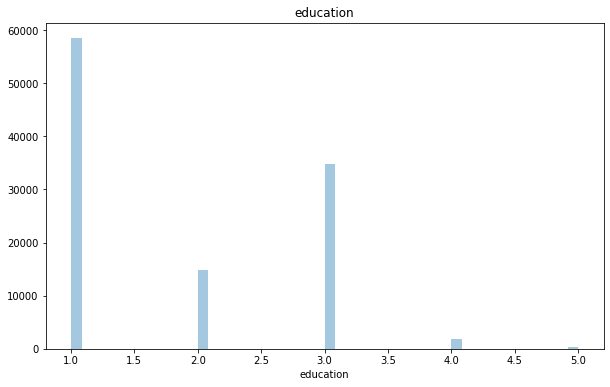

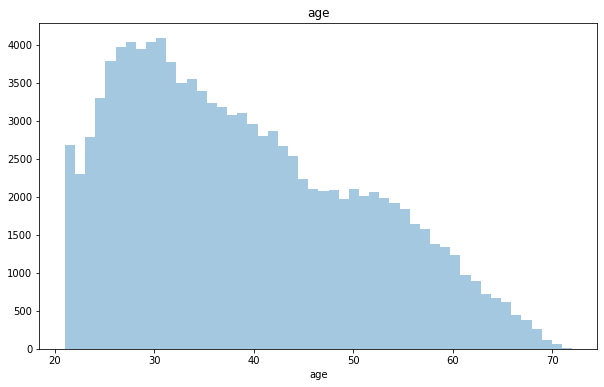

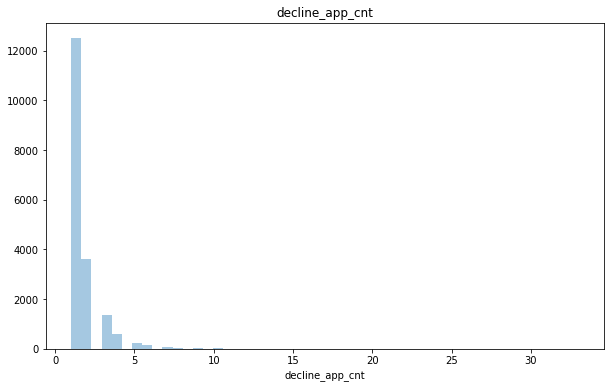

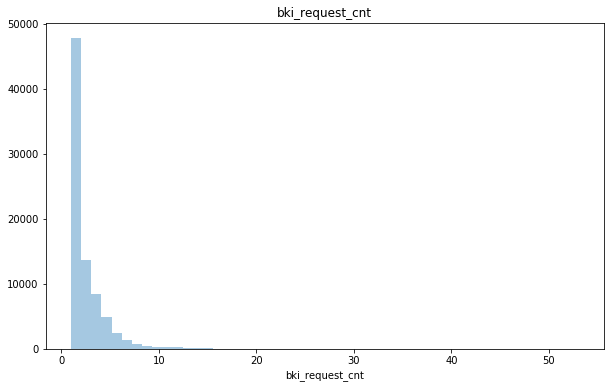

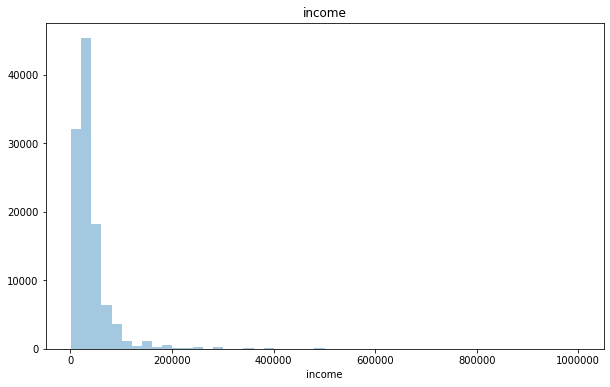

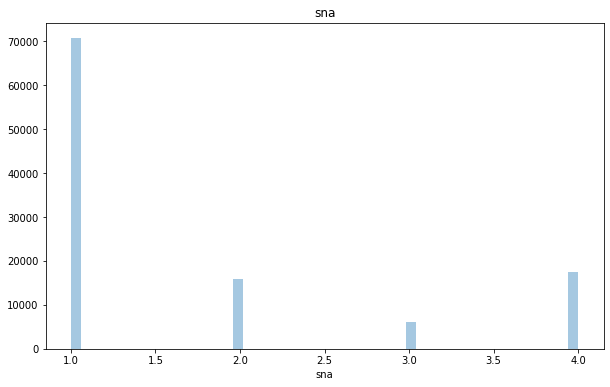

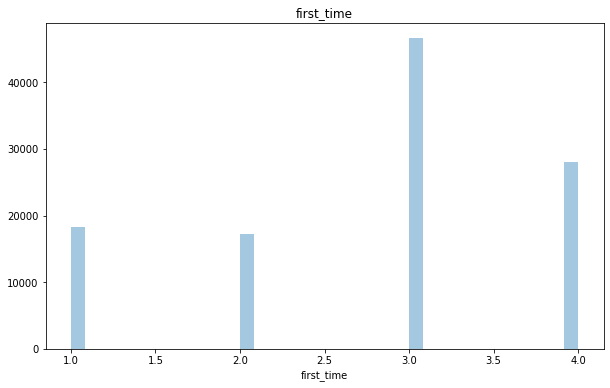

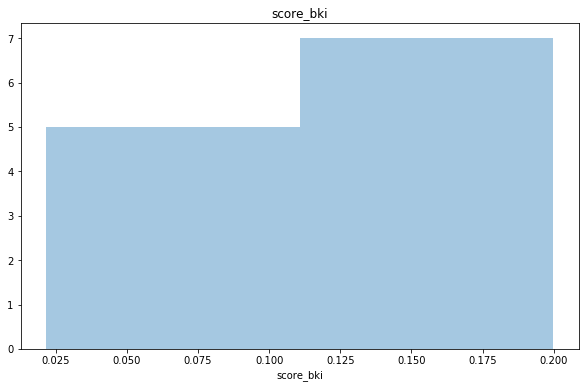

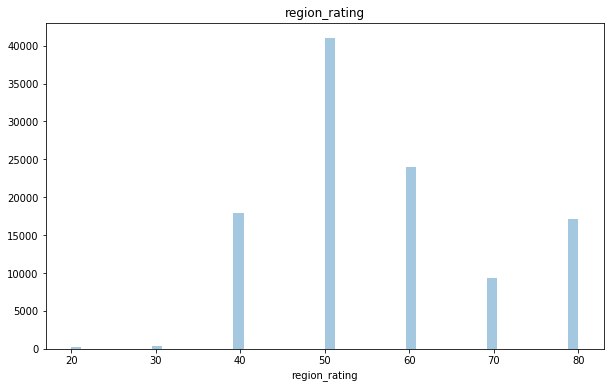

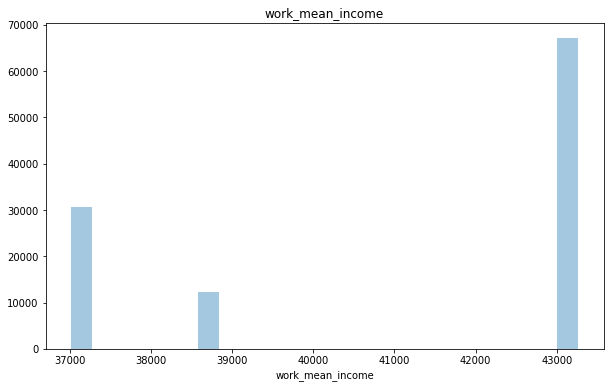

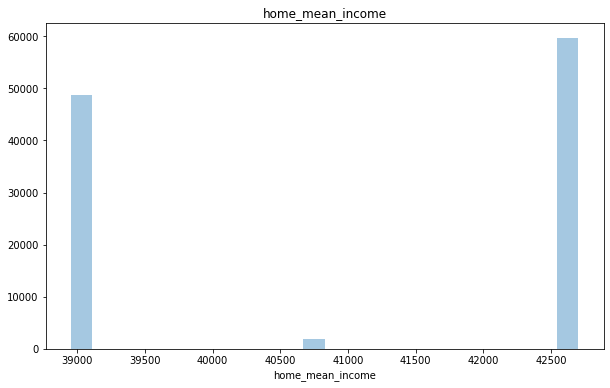

In [5954]:
for i in num_col:
    plt.figure(figsize=(10,6))
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

##### Для того, чтобы сделать распределение данных более нормальным, можно работать с логарифмированными величинами этих переменных. Тогда можно избежать чувствительности к сильным отклонениям

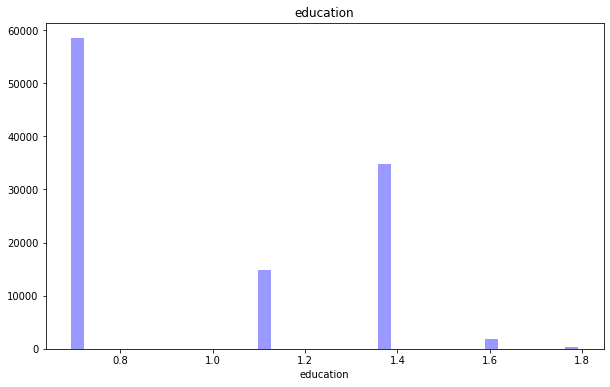

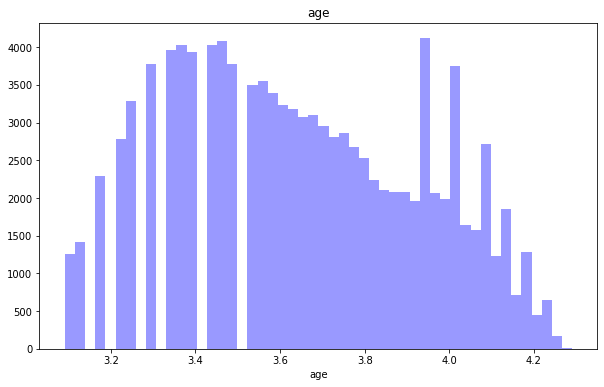

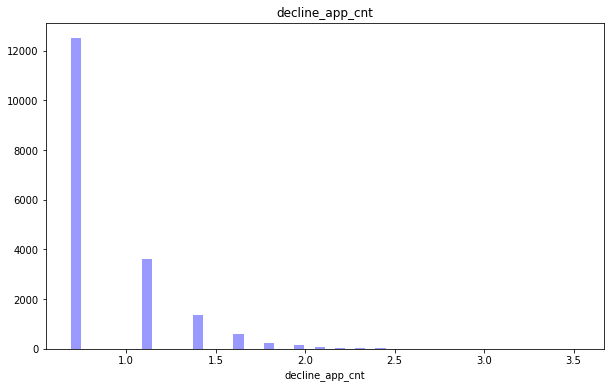

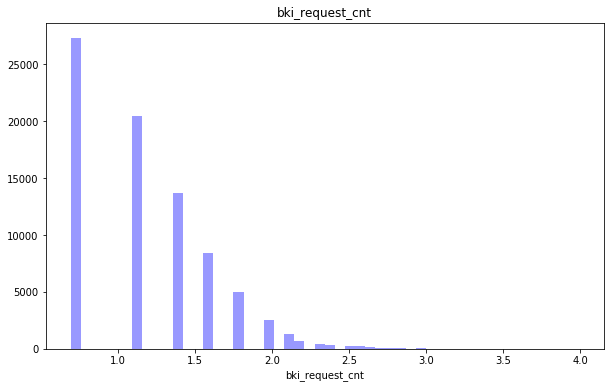

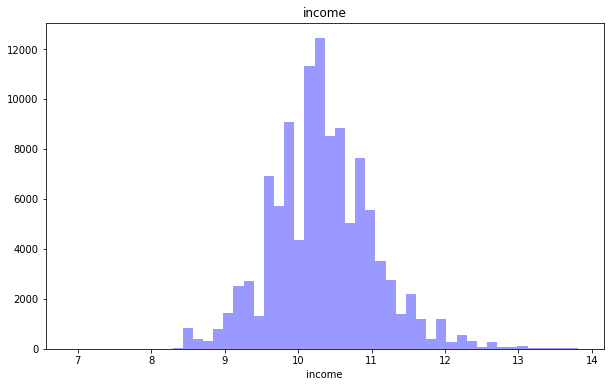

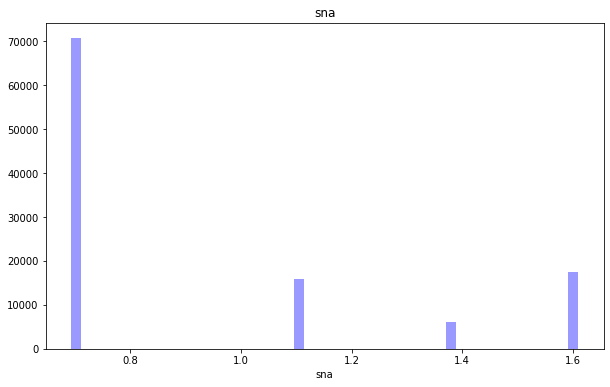

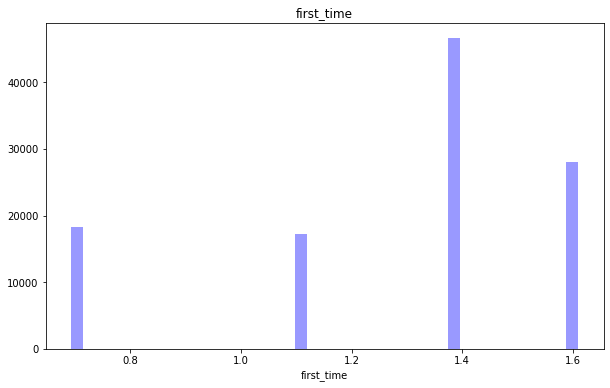

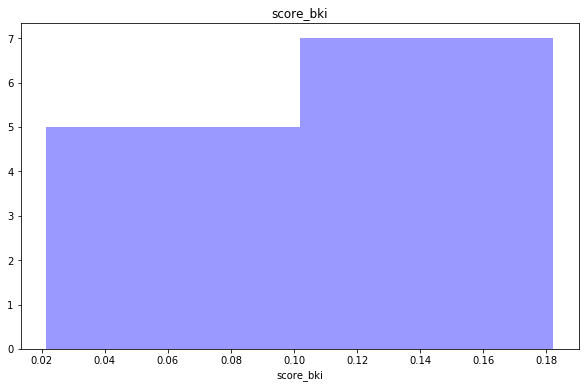

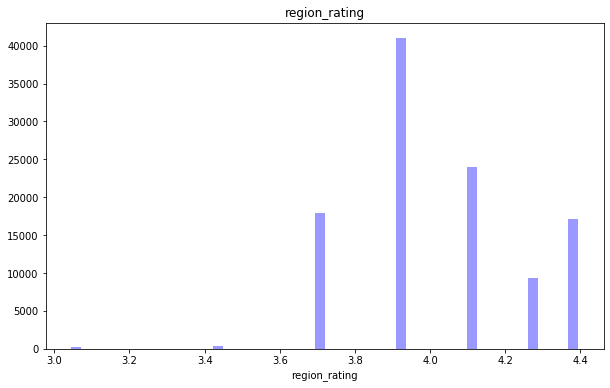

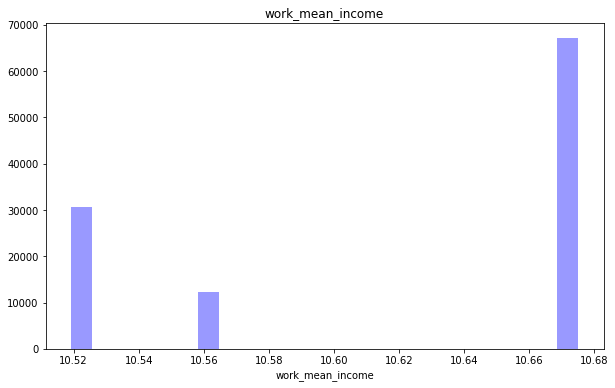

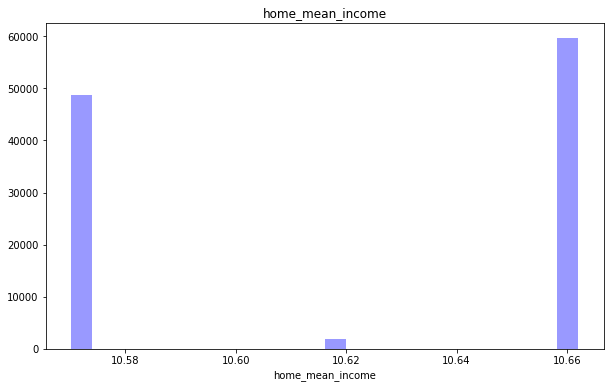

In [5955]:
for i in num_col:
    data[i] = np.log(data[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False, color='b')
    plt.title(i)
    plt.show()

##### Посмотрим на корреляцию признаков

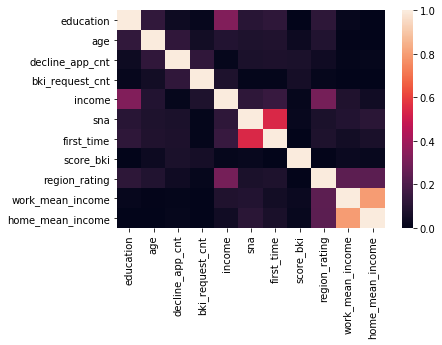

In [5956]:
sns.heatmap(data[num_col].corr().abs(), vmin=0, vmax=1)

Для удобства построим таблицу корреляции

In [5957]:
data[num_col].corr()

,education,age,decline_app_cnt,bki_request_cnt,income,sna,first_time,score_bki,region_rating,work_mean_income,home_mean_income
education,1.000000,-0.130345,-0.035362,0.016971,0.324250,-0.106229,0.122535,0.000710,0.119610,0.017886,0.003130
age,-0.130345,1.000000,-0.128624,0.050241,-0.090734,-0.078449,0.082976,0.031839,-0.089568,-0.006105,0.000355
decline_app_cnt,-0.035362,-0.128624,1.000000,0.127531,-0.013959,0.071713,-0.075172,0.073857,-0.041041,0.009449,0.011787
bki_request_cnt,0.016971,0.050241,0.127531,1.000000,0.078649,0.010290,0.009009,0.055911,-0.014160,0.000392,0.001231
income,0.324250,-0.090734,-0.013959,0.078649,1.000000,-0.124610,0.147319,0.012851,0.297657,0.083513,0.046444
sna,-0.106229,-0.078449,0.071713,0.010290,-0.124610,1.000000,-0.544820,0.019885,-0.072833,0.090769,0.110787
first_time,0.122535,0.082976,-0.075172,0.009009,0.147319,-0.544820,1.000000,0.002493,0.078461,-0.050627,-0.068482
score_bki,0.000710,0.031839,0.073857,0.055911,0.012851,0.019885,0.002493,1.000000,0.005402,0.028883,0.022025
region_rating,0.119610,-0.089568,-0.041041,-0.014160,0.297657,-0.072833,0.078461,0.005402,1.000000,0.241278,0.234543
work_mean_income,0.017886,-0.006105,0.009449,0.000392,0.083513,0.090769,-0.050627,0.028883,0.241278,1.000000,0.799641


Из матрицы можем увидеть, что количество отказанных прошлых заявок прямо пропорционально с количеством запросов в БКИ, но при этом образование или возраст не являются поводом для отказа в кредите. Рейтинговый балл в БКИ в основном строится на основе возраста клиента, количества запросов в БКИ, заработной платы клиента, связи заемщика с банком.

Видно, что сильно коррелируют данные, связанные с рейтингом региона, рейтингом работы и доходом. Скоринговый бал больше всего коррелирует с количеством отказанных прошлых заявок, что логично. но обратно коррелирует с давностью наличия информации о заемщике.

Чем больше зарплата, тем меньше у человека отказов в кредите

Удалим столбец score_bki, так как на данном этапе имеем признак, связывающий возраст клиента и рейтинг в БКИ

In [5958]:
del data['score_bki']

Можно увидеть, что некоторые данные имеют большие выбросы. Уберем эти выбросы. Воспользуемся формулой межквартильного размаха

In [5959]:
def med(df, col):
    med1=df[col].median()
    IQR=df[col].quantile(0.75)-df[col].quantile(0.25)
    perc25=df[col].quantile(0.25)
    perc75=df[col].quantile(0.75)
    df.loc[df[col].between(perc25-1.5*IQR,perc75+1.5*IQR)]

In [5960]:
med(data, 'age')
med(data, 'sna')

Создадим дополнительные признаки для улучшения качества модели

In [5961]:
data['bki_request_cnt_log'] = np.log(data['bki_request_cnt'] + 1)

## Подготовка данных к машинному обучению

##### Сделаем из признаков app_month, sex, home_address, work_address dummies переменные

In [5962]:
cat_cols = ['app_month', 'sex', 'work_address', 'home_address']
data= pd.get_dummies(data, columns=cat_cols, dummy_na=False)
data

,client_id,app_firs_month_day,app_second_month_day,education,age,car,car_type,decline_app_cnt,good_work,bki_request_cnt,...,app_month_January,app_month_March,sex_Female,sex_Male,work_address_1,work_address_2,work_address_3,home_address_1,home_address_2,home_address_3
0,74835,0,1,1.386294,3.401197,1,1,0.000000,0,1.386294,...,0,1,0,1,0,1,0,1,0,0
1,17527,0,1,0.693147,3.688879,0,0,1.791759,0,1.098612,...,1,0,1,0,0,1,0,1,0,0
2,75683,0,1,1.098612,3.931826,1,1,0.000000,0,0.693147,...,0,1,0,1,0,1,0,1,0,0
3,26883,1,0,0.693147,4.043051,0,0,0.000000,0,0.693147,...,0,0,0,1,0,1,0,1,0,0
4,28862,1,0,1.386294,3.663562,0,0,0.000000,0,0.000000,...,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,54887,1,0,1.386294,3.828641,0,0,0.000000,0,1.386294,...,0,1,1,0,0,1,0,1,0,0
110144,76821,0,1,0.693147,3.737670,1,1,0.000000,0,0.693147,...,0,1,0,1,0,1,0,0,1,0
110145,103695,0,1,0.693147,3.465736,0,0,0.000000,0,1.609438,...,0,0,0,1,0,0,1,0,1,0
110146,861,1,0,0.693147,3.401197,0,0,0.000000,1,1.386294,...,1,0,1,0,0,0,1,1,0,0


##### Разделим выборку на тестовую и обучающую. Отдельно сохраним данные с id клиента

In [5963]:
train = data.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test = data.query('sample == 0').drop(['default'], axis=1)
id_sub = test[['client_id', 'sample']]

In [5964]:
test.drop(['client_id', 'sample'], axis = 1, inplace=True)
id_sub.drop(['sample'], axis=1, inplace=True)

In [5965]:
X = train.drop(['default'], axis=1)
y = train['default']


Разделим модель на тестовую и тренировочную

In [5966]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.20, random_state=RANDOM_SEED)

Подготовка признаков для модели завершена

#### Обучим модель на стандартных настройках логистической регрессии

In [5967]:
model = LogisticRegression()

In [5968]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Проверка качества модели

Построим ROC кривую, которая показывает зависимость количества верно классифицированных положительных примеров от количества неверно классифицированных отрицательных примеров.

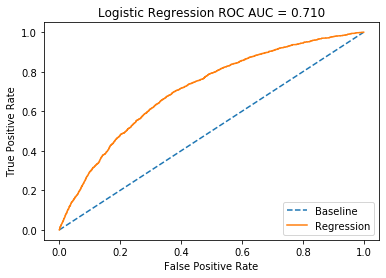

In [5969]:
from sklearn.model_selection import GridSearchCV

probs = model.predict_proba(X_test)
probs = probs[:,1]
y_pred = model.predict(X_test)


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Посчитаем метрики Precision, recall, f1_score

In [5970]:
print(precision_score(y_test, y_pred))

0.47540983606557374


In [5971]:
print(recall_score(y_test, y_pred))

0.015873015873015872


In [5972]:
print(f1_score(y_test, y_pred))

0.030720338983050845


Доля объектов, действительно принадлежащих нужному классу в данной модели составляет 0.47. Полнота модели мала. Модель требует улучшения. Но ножно заметить, что предсказанные значения получаются не случайно, а по определенному правилу. Модель обучается. 

Попробуем улучшить модель с помощью регуляризации.

## Регуляризация

Сделаем регуляризацию, и учтем гиперпараметры. 

Гиперпараметры - это внешние параметры для классификатора, которые не могут быть изучены самим классификатором. 

Логистическая регрессия не способна сама выучить наилучшее значение для, например, параметра С. Найдем оптимальный параметр и попробуем улучшить предсказательную силу модели. Найдем оптимальное значение параметра регуляризации для логистической регрессиию

In [5973]:
from sklearn.model_selection import GridSearchCV
warnings.simplefilter('ignore')

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 8)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression()
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 193.06977288832496


Обучим модель с учетом регуляризации

In [5974]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)


In [5975]:
new_model = LogisticRegression(random_state = RANDOM_SEED, 
                               C = 193.06977288832496, 
                               penalty = 'l2')
new_model.fit(X_train, y_train)

LogisticRegression(C=193.06977288832496, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

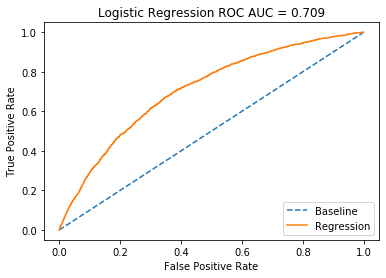

In [5976]:
from sklearn.model_selection import GridSearchCV

probs = new_model.predict_proba(X_test)
probs = probs[:,1]
y_pred = new_model.predict(X_test)


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Посчитаем метрики Precision, recall, f1_score

In [5977]:
print(precision_score(y_test, y_pred))

0.48333333333333334


In [5978]:
print(recall_score(y_test, y_pred))

0.015873015873015872


In [5979]:
print(f1_score(y_test, y_pred))

0.03073661897191309


С помощью регуляризации удалось немного увеличить точность модели. 

In [5980]:
data_train = data.query('sample == 1').drop(['sample', 'client_id'], axis=1)
data_test = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

In [5981]:
X_train = data_train.drop(['default'], axis=1)
y_train = data_train['default'].values
X_test = data_test.drop(['default'], axis=1)

## Submission

In [5982]:
lgr = LogisticRegression(penalty = 'l2', C=193.06977288832496)
lgr.fit(X, y)
probs = lgr.predict_proba(X_test)
probs = probs[:,1]

In [5983]:
my_submission = pd.DataFrame(data.query('sample == 0')['client_id'])
my_submission['default'] = probs
my_submission.to_csv('submission.csv', index=False)

In [5984]:
my_submission

,client_id,default
0,74835,0.065545
1,17527,0.363773
2,75683,0.042891
3,26883,0.126549
4,28862,0.057892
...,...,...
36344,83775,0.399941
36345,106254,0.023386
36346,81852,0.203968
36347,1971,0.180453


Вывод: Скоринговая модель предсказания дефолта клиентов банка реализована. Модель может предсказывать значения, но не идеально. 